# Droplet spreading over a flat surface against static contact angle $\theta_e$ -         Mesh convergence study
![Droplet_Spreading domain configuration](DropletSpreading.png)

For this case study, we have considered a droplet spreading on a flat surface ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034)) that allows for studying the effect of the static contact angle boundary condition and the Bond number, $Bo = \frac{\rho_l g R_0}{\sigma}$ on the equilibrium shape of the droplet. Ideally, for a droplet that spreads with $Bo\ll1$, surface tension forces dominate, and the droplet at equilibrium maintains a spherical cap shape and satisfies the contact angle boundary condition. On the other hand, for $Bo\gg1$, the gravitational forces dominate, and the droplet forms a puddle, whose height is directly proportional to the capillary length, $l_{Ca}=\sqrt{\frac{\sigma}{\rho_l g}}$. The conservation of the droplet’s volume $V$ with an equilibrium contact angle $\theta_e$ allows formulating the geometrical relations that define the equilibrium shape of the droplet ([dupont2010numerical](https://doi.org/10.1016/j.jcp.2009.07.034), [fricke2020geometry](https://arxiv.org/abs/2003.04914)). In addition to observing droplets at equilibrium, we have also studied the mesh convergence of the spreading droplets.

This notebook shows the droplet spreading in the absence of gravity against a range of static contact angles $\theta_e$

#### Note: water_glycerol and water are labelled as 'wg' and 'w' respectively.



Droplet Volume = 2.0943951023931954e-09
modules path:  /home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/DropletSpreadingTest/ZeroG/../../modules


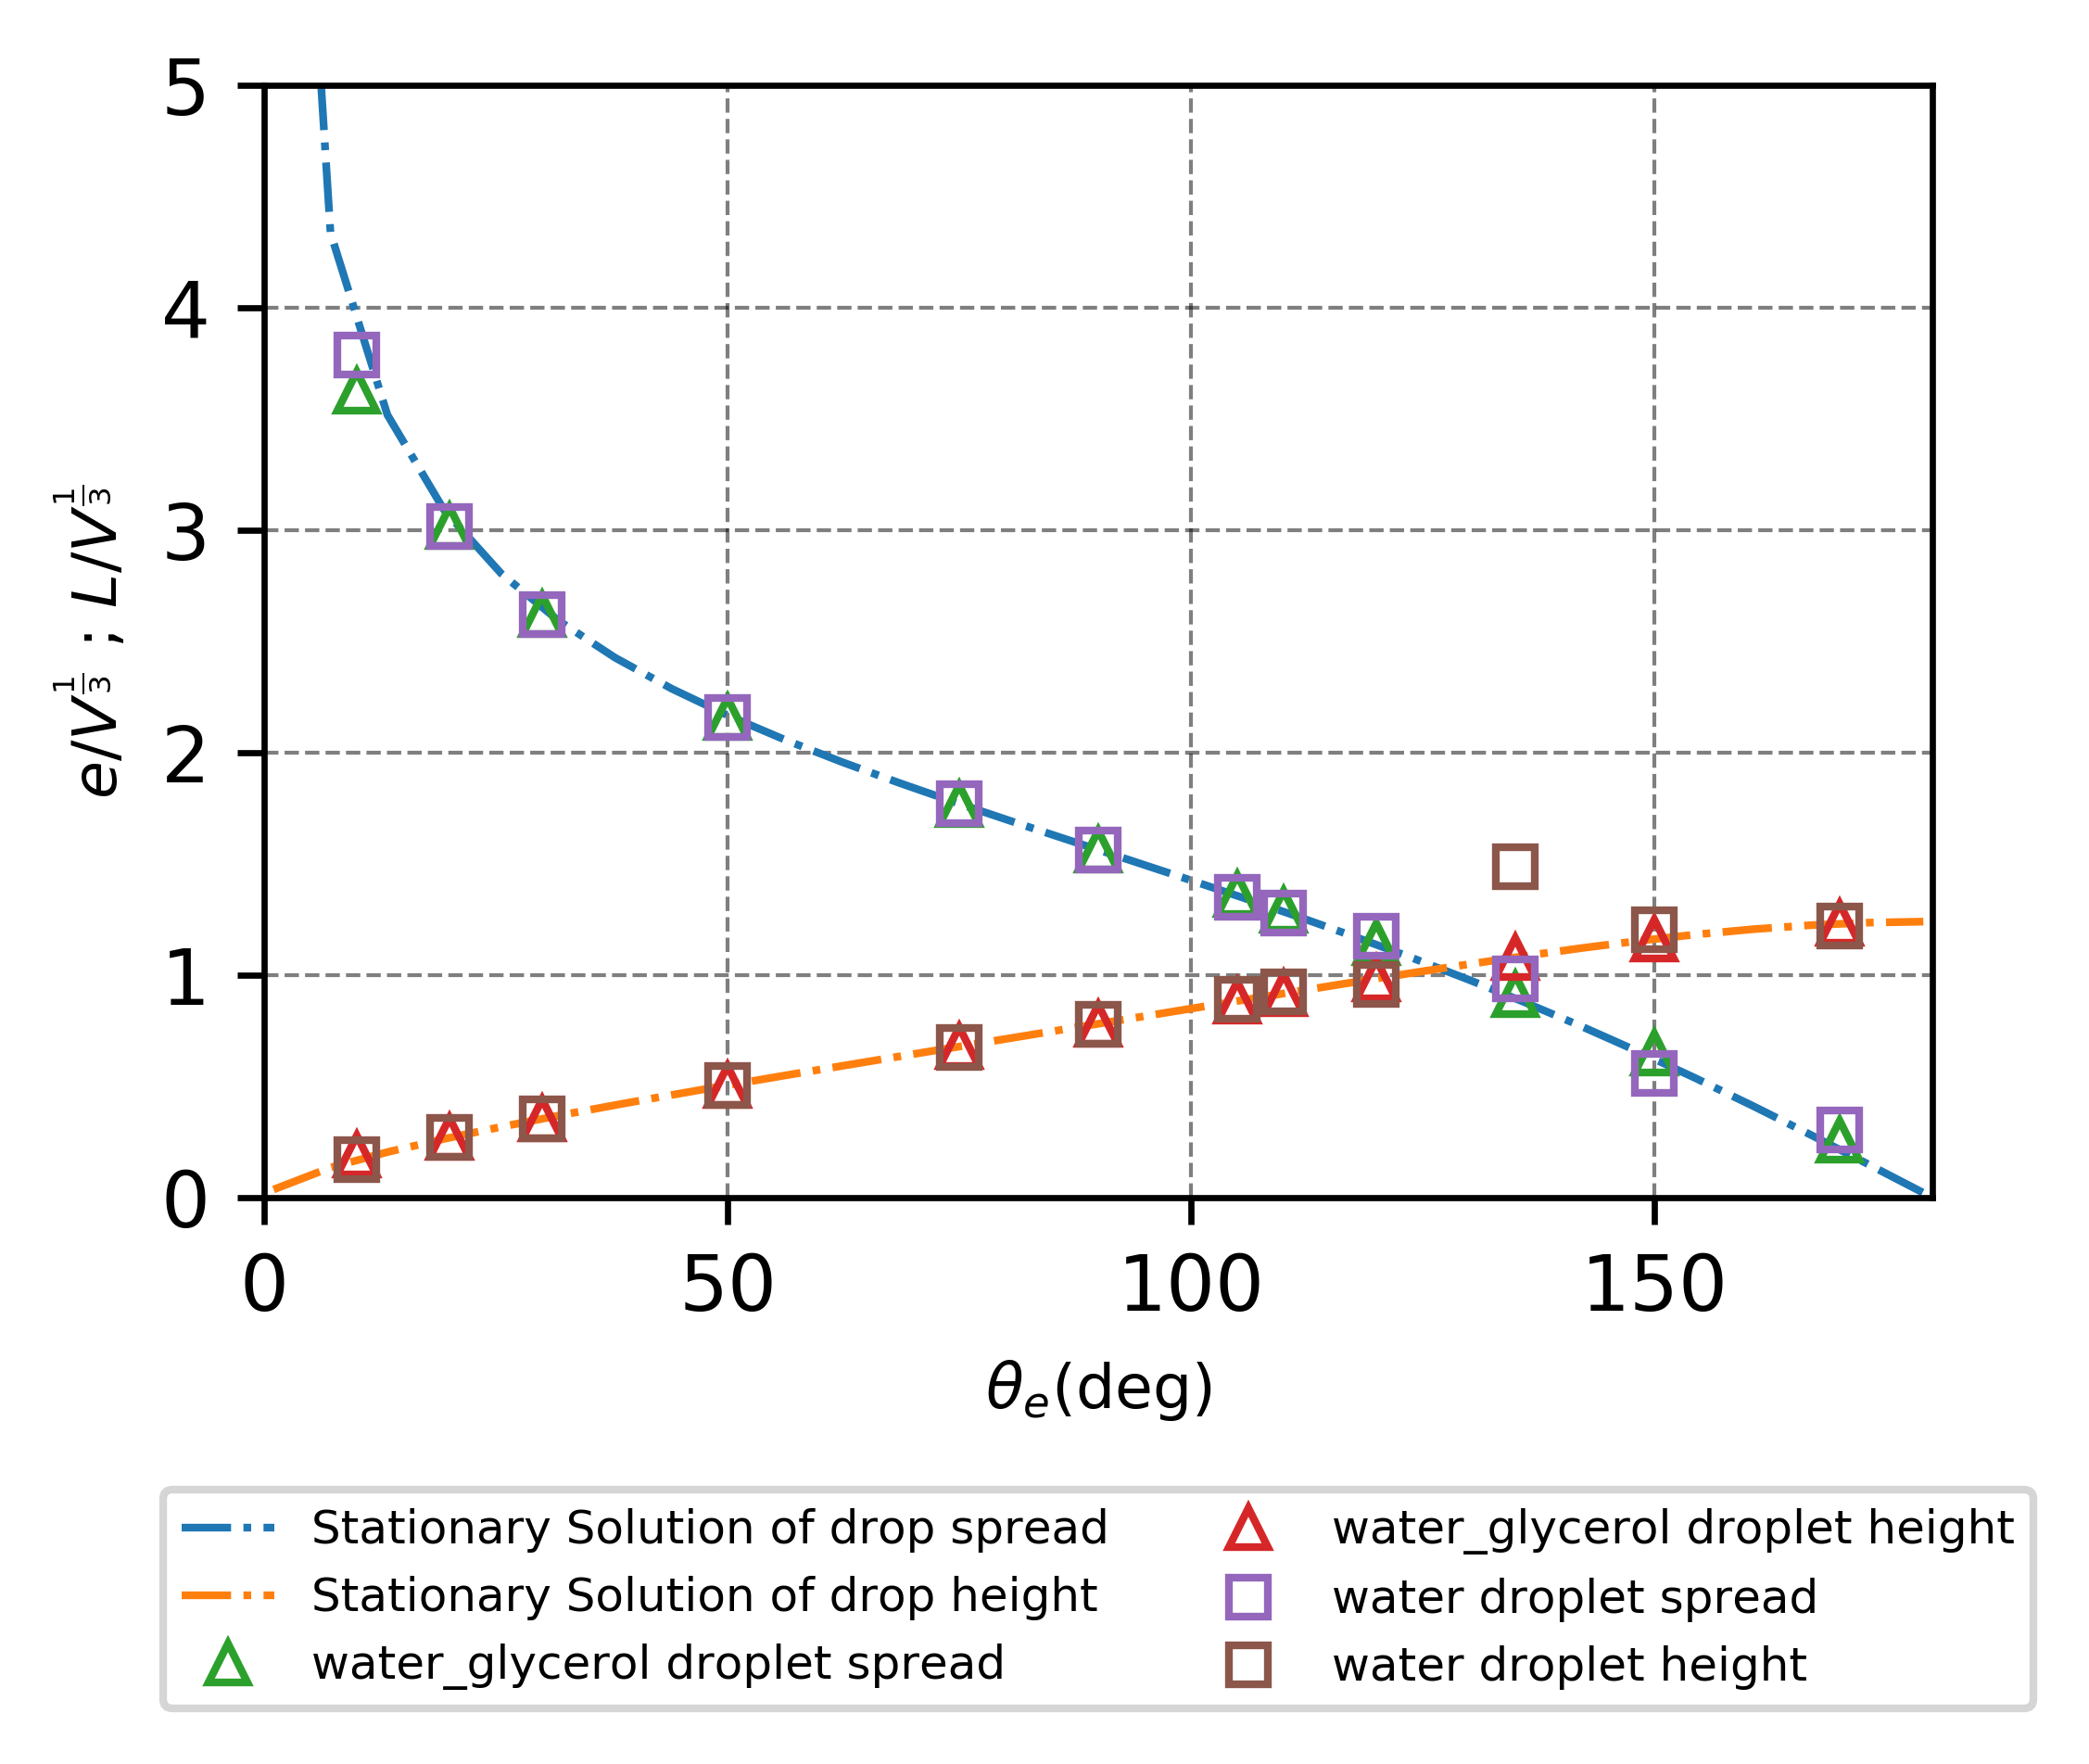

In [2]:
#Loading the necessary files
import pandas as pd
import numpy as np
from vtk import vtkStructuredPointsReader
from vtk.util import numpy_support as VN
import csv
import sys
# for radians
import math
import os
import matplotlib.pyplot as plt
import re
import itertools
import ast
from matplotlib import rcParams
pi =np.pi
sin = np.sin
cos = np.cos
dpi =600
fontSize =8


fluids = ['water_glycerol' , 'water'] 
surfaceTensionModel = 'RDF' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
dataFolder = '/postProcessing/' #folder with .csv files
pattern = 'test_'
calcHeights = False #True is new simulation is run and height.csv file is needed to be updated from vtk files
dropletRadius = 0.001 #R0
dropletVolume = 4/(2*3) * pi * dropletRadius**(3) #2 is because of semi-sphere, remove it for a full sphere
print('Droplet Volume = ' + str(dropletVolume) )

sys.path.append(os.path.join(os.getcwd(), '../../modules'))
print('modules path: ',os.path.join(os.getcwd(), '../../modules'))
from flat_spreading_funcs import Funcs

#######################################################################################
#Reference solutions

SCA_List = np.linspace(1, 179, 30) #for semi-sphere initialization
L_List = [None] * 30 ##spread analytical -> wetted diameter
e_List = [None] * 30 #analytical height

for i, val in enumerate(SCA_List):
    theta = math.radians(SCA_List[i]) 
    L_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[0] *2/(dropletVolume**(1/3)) #non-dimensional
    e_List[i] = Funcs.getAnalyticalWettedRadiusByVolume(theta,dropletVolume)[1] /(dropletVolume**(1/3)) #non-dimensional

###############################################################################################################
#Plot equilibrium spread against static contact angle
fig = plt.figure(0)
myaxes = fig.add_axes([0.1, 0.1, 0.5, 0.5])
rcParams["figure.dpi"] = dpi
plt.plot(SCA_List, L_List, linewidth=1, linestyle='dashdot', label = r"Stationary Solution of drop spread")
plt.plot(SCA_List, e_List, linewidth=1, linestyle='dashdot', label = r"Stationary Solution of drop height")

#############################################################################################################
wettedAreaFileNames = [] # list to stores the wetted area files to plot
vtk_folders = [] # list to store vtk files to calculate the height of the surface
heightFileNames = [] # list of file names that stores the height of the droplet
dropVol = [] # droplet volume list to store, efffective if the droplet volume is not consistent in parametric cases 

def plot(fluid):
    simStaticCAList= [] # static contact angles used for simulations taken from the variation file
    stm = [] # surface tension models in all cases,taken from the variation file
    var_list = [] # variance number of the parametric study of a specific case
    
    #variables for plots for water-glycerol
    plotLabels = [r"water_glycerol droplet spread",
              r"water_glycerol droplet height"]
    fluidLabel = 'wg'
    markerLabel = '^'
    
    #variables for plots for water
    if (fluid=='water'):
        plotLabels = [r"water droplet spread",
              r"water droplet height"]
        fluidLabel = 'w'
        markerLabel = 's'
    
    #read the variation-file to get the parameters map that is saved using pyFOAM
    var_Map = Funcs.fileMapping(fluidLabel+pattern, surfaceTensionModel)
    for key, value in var_Map.items():
        stm_map = str(value).split(', ')[0][:-1] #surface tension model map
        stm.append(stm_map.split(': ')[1][1:])
        theta_map = str(value).split(', ')[1][:-1] #contact angle map
        simStaticCAList.append(int(theta_map.split(': ')[1][0:]))
        var_list.append(str(key))  

    
    wettedAreaFileNames = Funcs.fileStructure(dataFolder, 'wettedArea.csv', fluidLabel+pattern, var_list )
    vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', fluidLabel+pattern, var_list)
    heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', fluidLabel+pattern,var_list)
    dropVol = Funcs.fileStructure('/system/', 'vofInitDict', fluidLabel+pattern,var_list)
    #print(dropVol)
    #print(vtk_folders)
    #print(heightFileNames)
    
    Funcs.writeHeightFile(calcHeights, wettedAreaFileNames, vtk_folders, heightFileNames)
    plt.grid(b=True, which='major', color='black', alpha=0.5, lw=0.5, linestyle='dashed')
   # plt.title(r'Geometrical chracteristics of the drop' +'\n' + r'against static contact angle $\theta_s$', fontsize=fontSize)
    plt.xlabel(r"$\theta_e$"+"(deg)" ,color='black',fontsize=fontSize)
    plt.ylabel(r"$e/V^\frac{1}{3}$ ; $L/V^\frac{1}{3}$",color='black',fontsize=fontSize)
    plt.legend(fontsize=fontSize, loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=2)
    plt.xlim([0, 180])
    plt.ylim([0, 5])


    equilibriumSpreadList= [None] *len(simStaticCAList) # to store the wetted radius from the simulation wettedArea file
    
    for idx, wettedFile in enumerate(wettedAreaFileNames):
        if(idx<9): #if statemennt because few simulations have full sphere and some have haf sphere droplet at t=t0
            dropletVolume = 4/(2*3) * pi * Funcs.getR(dropVol[idx])**(3)
        elif  (idx>9):
            dropletVolume = 4/(3) * pi * Funcs.getR(dropVol[idx])**(3)
        with open(wettedAreaFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            equilibriumSpreadList[idx] =(2.0*(float(last_line.rsplit(',', 1)[1]) /pi)**(1/2) / ((dropletVolume**(1/3))*1000.0))
    
    plt.plot(simStaticCAList, equilibriumSpreadList,
                marker=markerLabel,
                markerfacecolor='None', markersize = 5,
                linestyle = 'None', label=plotLabels[0])

    equilibriumHeightList= [None] *len(simStaticCAList)
    for idx, heightFile in enumerate(heightFileNames):  
        if(idx<9): #simulations with semi-sphere droplet initialization
            dropletVolume = 4/(2*3) * pi * Funcs.getR(dropVol[idx])**(3)
        elif  (idx>9): #simulations with spherical droplet initialization
            dropletVolume = 4/(3) * pi * Funcs.getR(dropVol[idx])**(3)
        with open(heightFileNames[idx], "r") as f1:
            last_line = f1.readlines()[-1]
            equilibriumHeightList[idx] =(float(last_line.rsplit(',', 1)[1]) / (dropletVolume**(1/3)))

    plt.plot(simStaticCAList, equilibriumHeightList,
                marker=markerLabel,
                markerfacecolor='None', markersize = 5,
                linestyle = 'None', label=plotLabels[1])
    
############################################################################################################

for fluid in fluids:
    plot(fluid)
    
plt.legend(fontsize=6, loc='lower center', bbox_to_anchor=(0.5, -.48), ncol=2)
plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.png', bbox_inches='tight')
plt.savefig('droplet-chractersitics-against-static-contact-angle'+'.pdf', bbox_inches='tight')
plt.show()


